# EDA on hourly wind power measurement and wind prediction dataset #

In [284]:
## load modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [285]:
# function to get wind direction out of zonal and meridional wind
def WDIR(u,v):
    return (180. + 180./np.pi * math.atan2(u,v)) % 360

### General structure of data ###

In [286]:
## read data and convert TIMESTAMP from string to pandas timestamp format
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data.csv')
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y%m%d %H')
data.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701


`A couple of missing values in TARGETVAR. Otherwise no missing values.`

In [287]:
## get info about type and shape of variables and about missing values in data
# only target variable has a couple of missing values 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175440 entries, 0 to 175439
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ZONEID     175440 non-null  int64         
 1   TIMESTAMP  175440 non-null  datetime64[ns]
 2   TARGETVAR  175265 non-null  float64       
 3   U10        175440 non-null  float64       
 4   V10        175440 non-null  float64       
 5   U100       175440 non-null  float64       
 6   V100       175440 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 9.4 MB


In [288]:
## look at some general statistics in data
# number of timestamps in record correspond to the maximum possible timestamps
print(data.describe())
print(f"\nfirst wind power generation measurement and wind forecast data: {data['TIMESTAMP'].min()}")
print(f"last wind power generation measurement and wind forecast data: {data['TIMESTAMP'].max()}")
print(f"Different zones: {data['ZONEID'].unique()}")
print(f"maximum number of timestamps to expect: {(data['TIMESTAMP'].max() - data['TIMESTAMP'].min())/np.timedelta64(1, 'h')+1}")

             ZONEID      TARGETVAR            U10            V10  \
count  175440.00000  175265.000000  175440.000000  175440.000000   
mean        5.50000       0.358588       0.818499       0.120835   
std         2.87229       0.310085       3.031781       3.105553   
min         1.00000       0.000000      -8.371644     -12.923576   
25%         3.00000       0.080344      -1.498648      -2.116981   
50%         5.50000       0.278670       0.548880       0.410020   
75%         8.00000       0.602033       2.805379       2.364026   
max        10.00000       1.000000      14.837177      11.401396   

                U100           V100  
count  175440.000000  175440.000000  
mean        1.272769       0.058513  
std         4.816235       5.096587  
min       -12.425352     -19.791997  
25%        -2.404248      -3.768786  
50%         1.053103       0.785671  
75%         4.734727       4.091509  
max        21.399071      16.304799  

first wind power generation measurement and 

`Remove NaN values.`

In [289]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175265 entries, 0 to 175433
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ZONEID     175265 non-null  int64         
 1   TIMESTAMP  175265 non-null  datetime64[ns]
 2   TARGETVAR  175265 non-null  float64       
 3   U10        175265 non-null  float64       
 4   V10        175265 non-null  float64       
 5   U100       175265 non-null  float64       
 6   V100       175265 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 10.7 MB


`Create columns with wind speed, date and time`

In [290]:
data['WS100'] = np.sqrt(data['U100']**2 + data['V100']**2)
data['WS10'] = np.sqrt(data['U10']**2 + data['V10']**2)
data['WDIR100'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U100'],x['V100'])) % 360),axis=1)
data['WDIR10'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U10'],x['V10'])) % 360),axis=1)
data['DATE'] = data['TIMESTAMP'].apply(lambda x: x.date())
data['TIME'] = data['TIMESTAMP'].apply(lambda x: x.time())

data.tail(20)


,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10,DATE,TIME
175414,10,2013-12-30 23:00:00,0.181852,-2.467382,-1.594376,-3.059065,-2.235852,3.789051,2.937688,53.837159,57.130209,2013-12-30,23:00:00
175415,10,2013-12-31 00:00:00,0.124739,-1.084894,-2.049906,-1.261436,-2.631194,2.917945,2.319291,25.613797,27.889611,2013-12-31,00:00:00
175416,10,2013-12-31 01:00:00,0.035165,0.120563,-2.893961,0.214695,-3.625221,3.631573,2.896471,356.610752,357.614419,2013-12-31,01:00:00
175417,10,2013-12-31 02:00:00,0.013587,1.561507,-2.326536,1.918621,-2.848615,3.434489,2.801976,326.038647,326.131579,2013-12-31,02:00:00
175418,10,2013-12-31 03:00:00,0.000430,1.718325,-1.956886,2.095780,-2.334851,3.137487,2.604235,318.088607,318.713904,2013-12-31,03:00:00
175419,10,2013-12-31 04:00:00,0.014693,1.614562,-1.554273,1.967832,-1.821086,2.681178,2.241110,312.782033,313.910046,2013-12-31,04:00:00
175420,10,2013-12-31 05:00:00,0.015062,1.487793,-0.954827,1.794363,-1.088392,2.098651,1.767830,301.239384,302.691315,2013-12-31,05:00:00
175421,10,2013-12-31 06:00:00,0.016906,1.342243,-0.737746,1.626431,-0.841860,1.831395,1.531628,297.366613,298.794821,2013-12-31,06:00:00
175422,10,2013-12-31 07:00:00,0.005779,0.609799,-0.480168,0.761551,-0.554553,0.942066,0.776155,306.061718,308.217647,2013-12-31,07:00:00
175423,10,2013-12-31 08:00:00,0.000000,-0.325476,-0.528670,-0.395519,-0.646767,0.758119,0.620828,31.447149,31.618578,2013-12-31,08:00:00


In [314]:
# time = [x.time() for x in pd.date_range(start="01-01-2012 00:00:00",end="01-01-2012 23:00:00", freq='H')]
# date = data['DATE'].unique()

# data_cf = pd.DataFrame(data=np.ones((len(date),len(time))) * np.nan, columns=time, index=date)
# data_temp = data.loc[data['ZONEID']==1][['TARGETVAR','DATE','TIME']]

# for d in data_cf.index:
#     for t in data_cf.columns:
#         print(d,t)
#         if ((data_temp['DATE']==d) & (data_temp['TIME']==t)).any():        
#             data_cf.loc[d,t] = data_temp.loc[(data_temp['DATE']==d) & (data_temp['TIME']==t),'TARGETVAR'].values[0]

# data_cf

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.dates import DateFormatter
# fontsize=20
# data_cf = data_cf.replace(0,np.nan)
# data_cf = data_cf[:90]

# fig,ax = plt.subplots(figsize=(22,5))
# divider = make_axes_locatable(ax)
# cf=ax.contourf(data_cf.index.to_list(),np.arange(24),data_cf.transpose(),levels=np.arange(0.,1.1,.1))#levels=np.concatenate([np.array([.001]),np.arange(.1,1.1,.1)]))
# ax.set_xlabel('date',fontsize=fontsize)
# ax.set_ylabel('hour of the day',fontsize=fontsize)
# cax = divider.append_axes('right',size='2%',pad=.05)
# cbar = fig.colorbar(cf, cax=cax)
# cbar.set_label('norm. wind power generation [-]',fontsize=fontsize)
# ax.set_title('time series of normalized wind power generation at site 1',fontsize=fontsize)
# ax.tick_params(axis='both',labelsize=20)
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

### Wind power and wind distributions for different wind parks ###

`Similar number of data for the different locations.`

In [296]:
## every wind park the same number of observations?
data.groupby('ZONEID').count()

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10,DATE,TIME
ZONEID,,,,,,,,,,,,
1,17526,17526,17526,17526,17526,17526,17526,17526,17526,17526,17526,17526
2,17523,17523,17523,17523,17523,17523,17523,17523,17523,17523,17523,17523
3,17450,17450,17450,17450,17450,17450,17450,17450,17450,17450,17450,17450
4,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
5,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
6,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
7,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
8,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
9,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538


Text(0.5, 1.0, 'all sites')

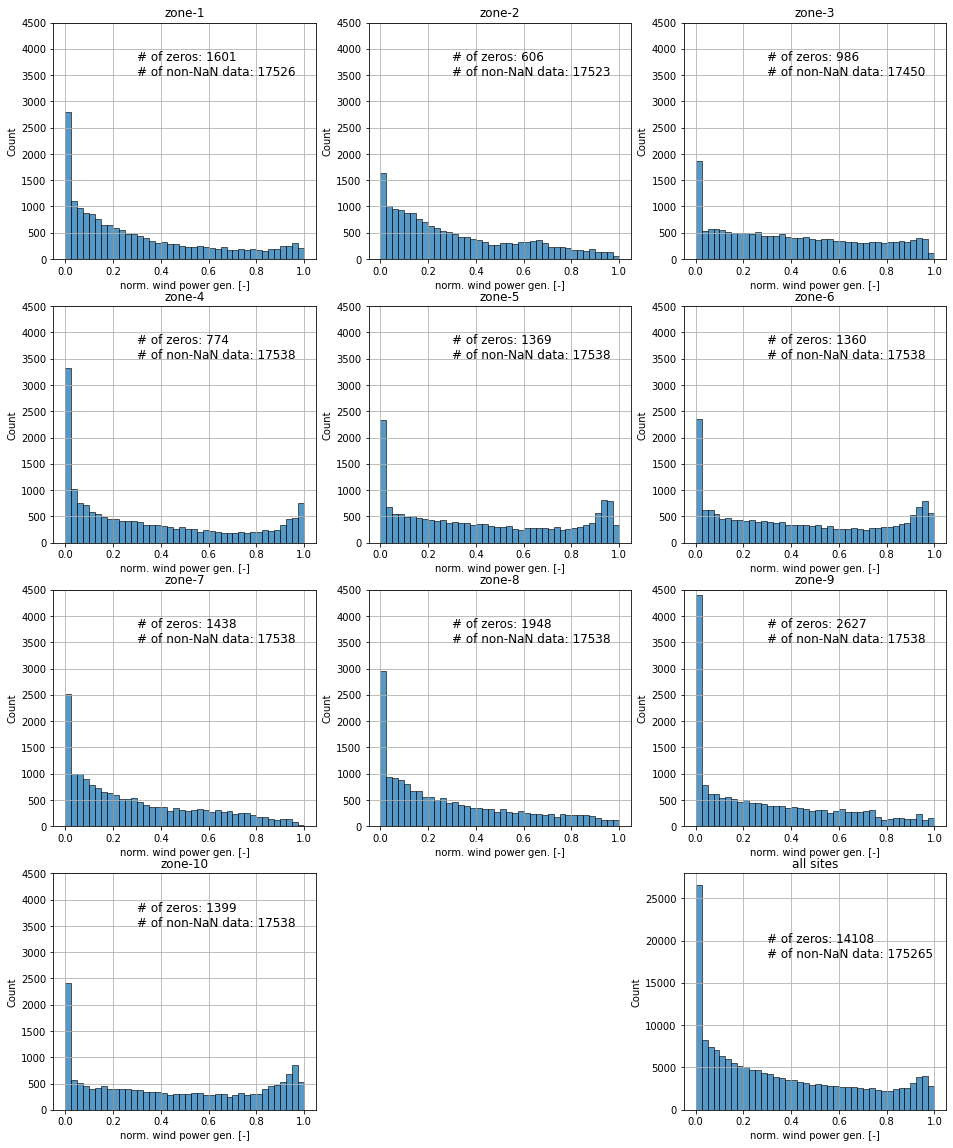

In [297]:
# distributions of wind power generation at the different sites
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(16,20))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data['TARGETVAR'].loc[data['ZONEID']==zone]
    sns.histplot(data=data_temp, ax=ax[i], bins=np.arange(0.,1.025,.025))
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel('norm. wind power gen. [-]')
    ax[i].set_ylim([0,4500])
    ax[i].grid()
    ax[i].text(.3,3500.,'# of zeros: {} \n# of non-NaN data: {}'.format((data_temp==0.).sum(),data_temp.count()),fontsize=12)
ax[-2].remove() 
sns.histplot(data=data['TARGETVAR'], ax=ax[-1], bins=np.arange(0.,1.025,.025))
ax[-1].grid()
ax[-1].set_xlabel('norm. wind power gen. [-]')
ax[-1].text(.3,18000.,'# of zeros: {} \n# of non-NaN data: {}'.format((data['TARGETVAR']==0.).sum(),data['TARGETVAR'].count()),fontsize=12)
ax[-1].set_title('all sites')

Text(0.5, 0, '100 m wind speed $\\mathregular{[m\\ s^{-1}]}$')

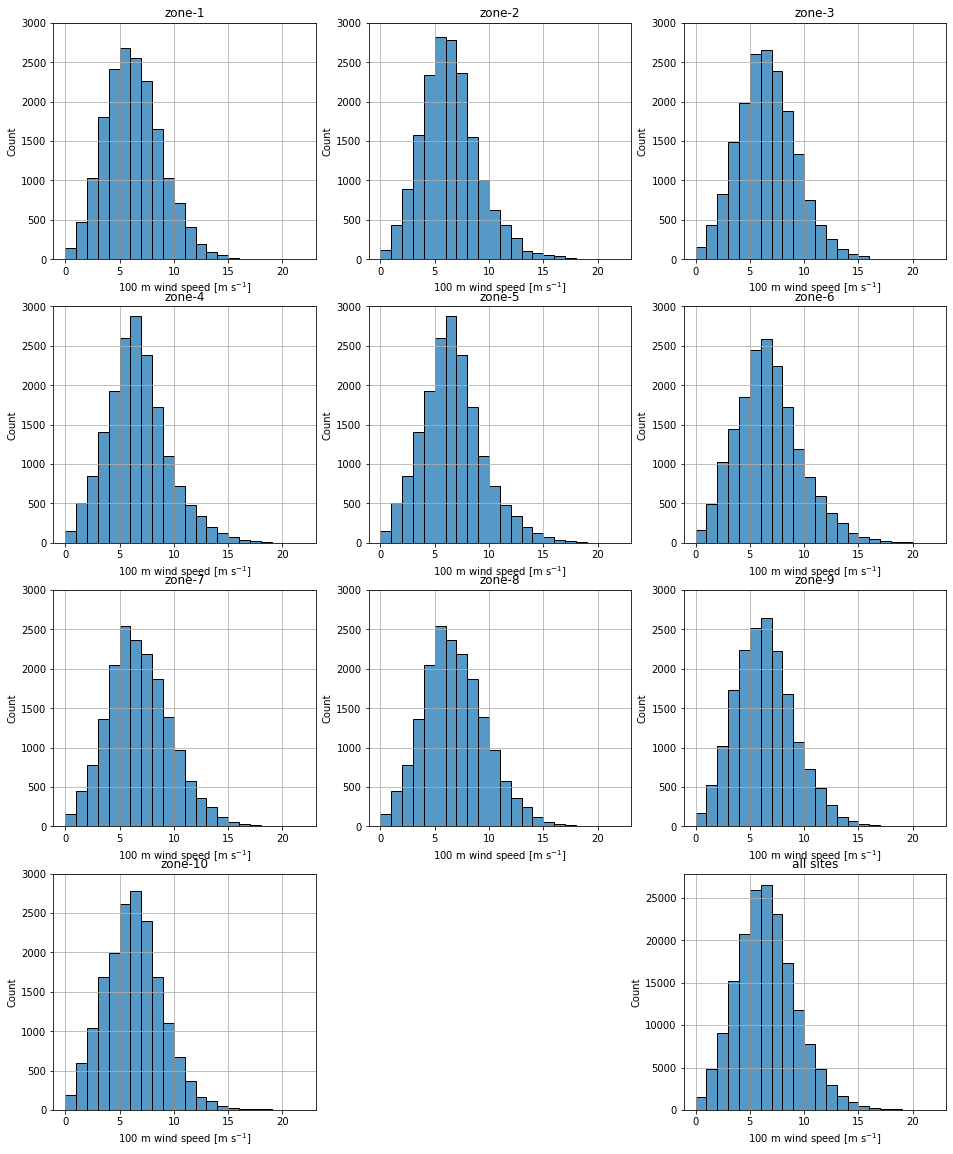

In [298]:
# distributions of wind speed at the different sites
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(16,20))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data['WS100'].loc[data['ZONEID']==zone]
    sns.histplot(data=data_temp, ax=ax[i], bins=np.arange(0.,23.,1.))
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel('100 m wind speed $\mathregular{[m\ s^{-1}]}$')
    ax[i].grid()
    ax[i].set_ylim([0,3000])
    
ax[-2].remove() 
sns.histplot(data=data['WS100'], ax=ax[-1], bins=np.arange(0.,23.,1.))
ax[-1].grid()
ax[-1].set_title('all sites')
ax[-1].set_xlabel('100 m wind speed $\mathregular{[m\ s^{-1}]}$')

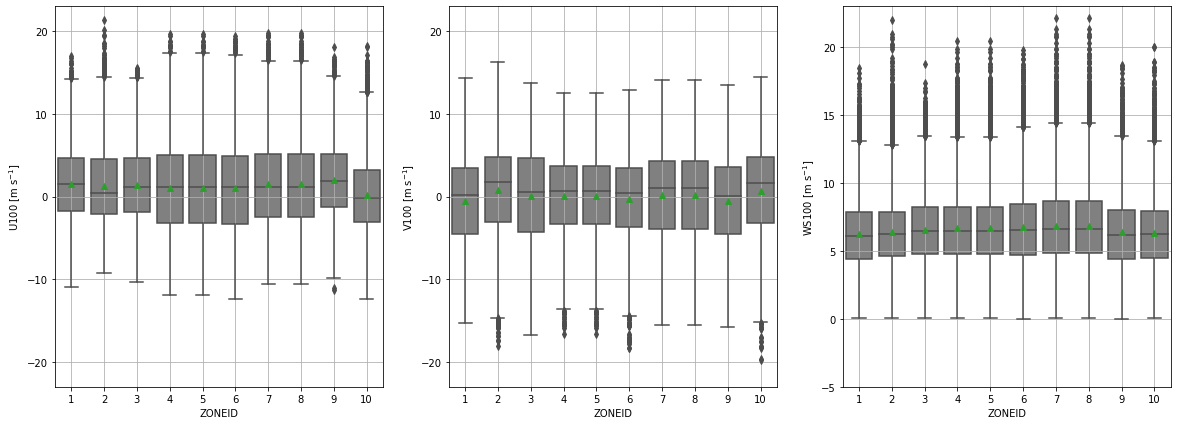

In [299]:
# distribution of zonal and meridional wind at the different sites
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
ax = np.reshape(ax,3)

for i,var in enumerate(['U100','V100','WS100']): 
    sns.boxplot(data=data, x='ZONEID', y=var, color='gray', showmeans=True, ax=ax[i])
    ax[i].grid()
    if i < 2:
        ax[i].set_ylim([-23.,23.])
    else:
        ax[i].set_ylim([-5.,23.])
    ax[i].set_ylabel('{} {}'.format(var,"$\mathregular{[m\ s^{-1}]}$"))

### Relationship between U100, V100 and wind power generation ###

In [337]:
0.05/0.35

0.14285714285714288

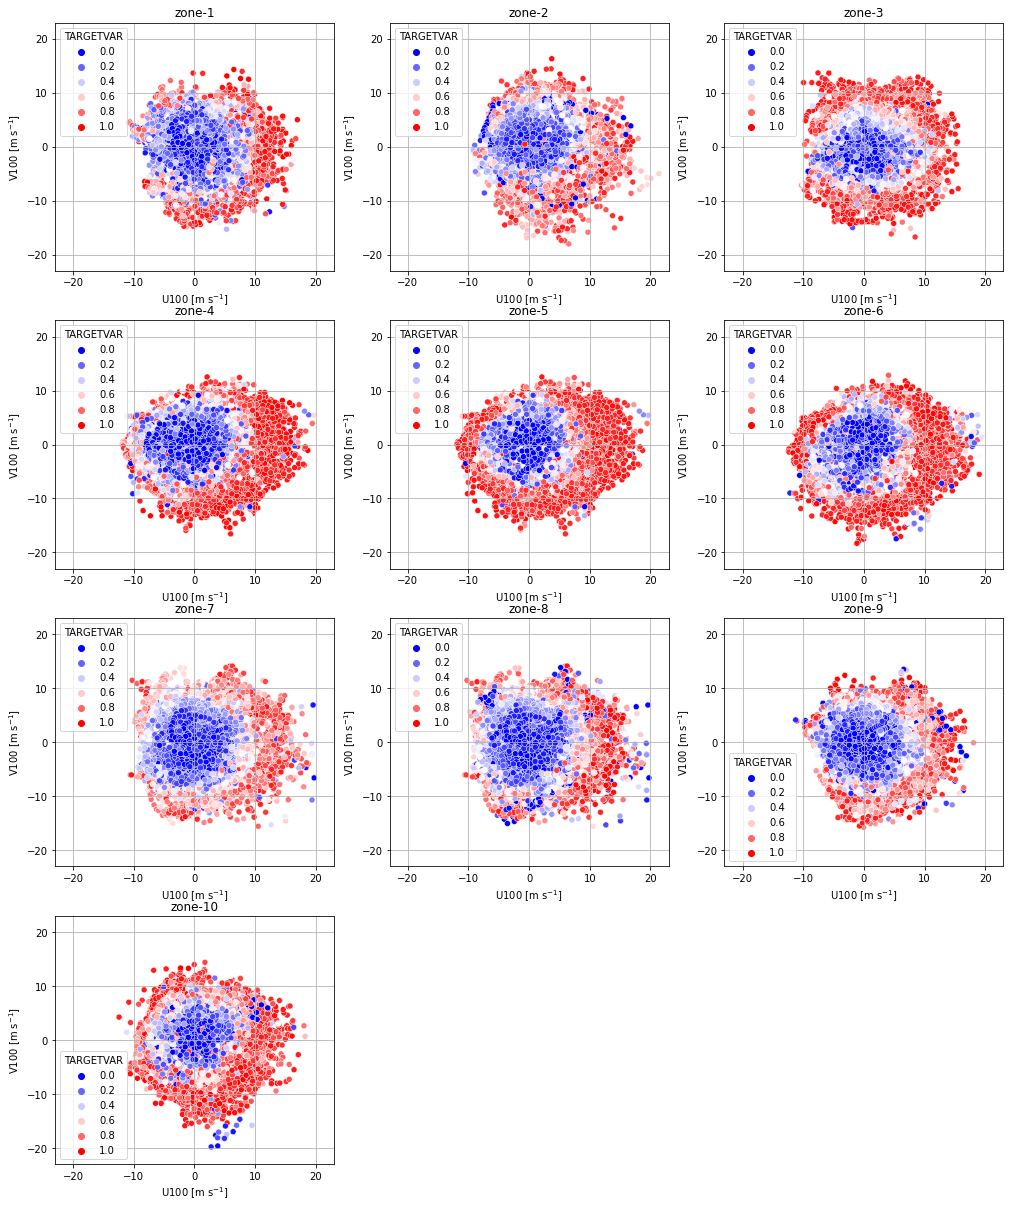

In [300]:
# scatter plots
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(17,21))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data.loc[data['ZONEID']==zone]
    sns.scatterplot(data=data_temp, x='U100', y='V100', hue='TARGETVAR', palette='bwr', ax=ax[i])
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel("U100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_ylabel("V100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_xlim([-23.,23.])
    ax[i].set_ylim([-23.,23.])
    ax[i].grid()
ax[-1].remove()
ax[-2].remove()

In [321]:
#c = np.arange()
import matplotlib.colors as colors
import matplotlib as mpl

#cmap = plt.get_cmap('bwr')
#colors.LinearSegmentedColormap.from_list(('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0, b=1.)), cmap(np.linspace(0,.5,100)))

colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(0.0, 2*np.pi)
norm

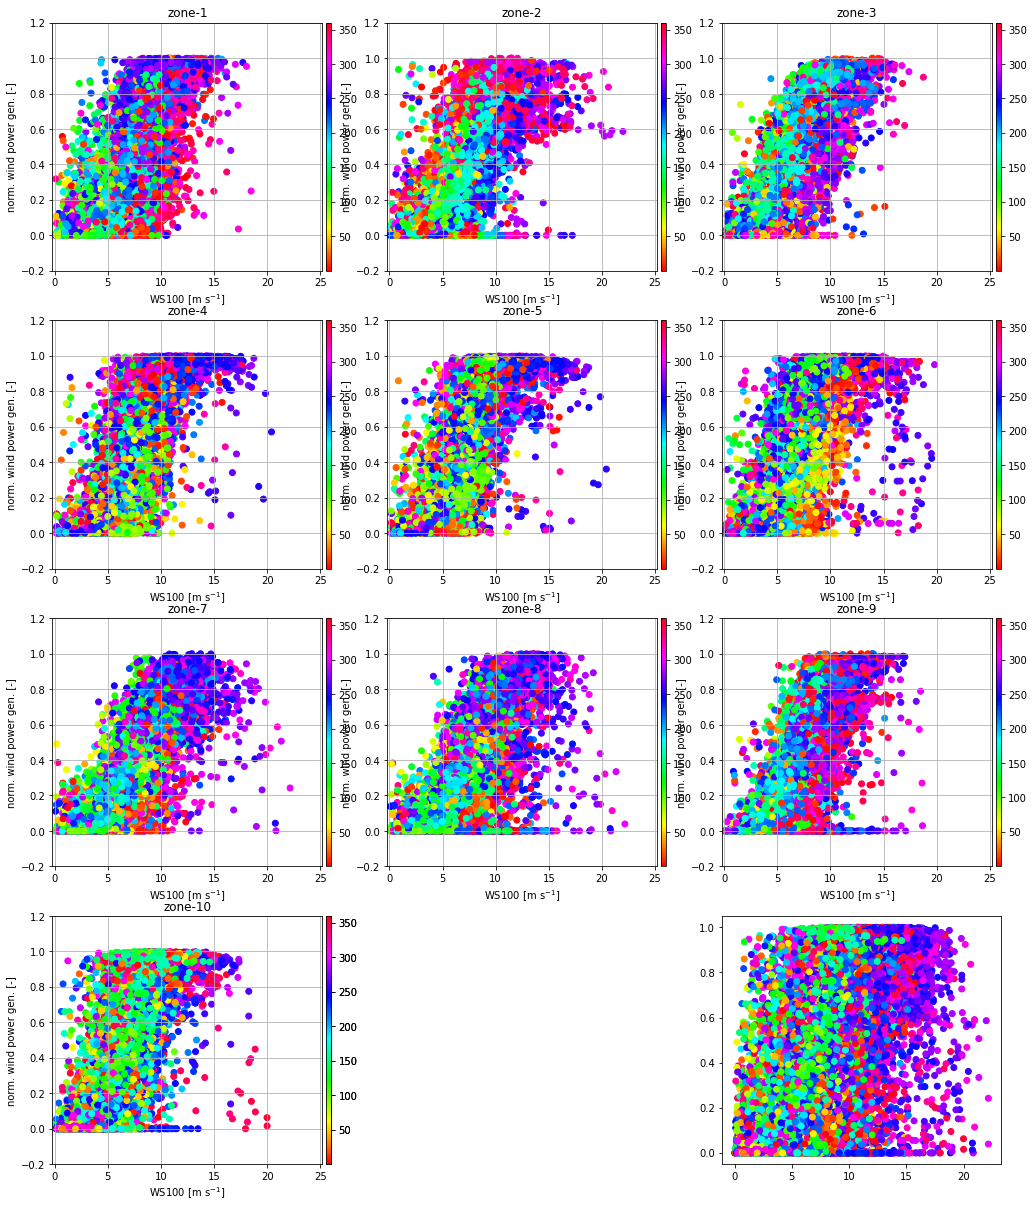

In [334]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(17,21))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data.loc[data['ZONEID']==zone]
    #cf = sns.scatterplot(data=data_temp, x='WS100', y='TARGETVAR', c=data_temp['WDIR100'],ax=ax[i],cmap='hsv')
    cf = ax[i].scatter(data_temp.WS100, data_temp.TARGETVAR, c=data_temp['WDIR100'], cmap='hsv')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right',size='2%', pad=.05) 
    cbar = fig.colorbar(cf, cax=cax)

    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel("WS100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_ylabel("norm. wind power gen. [-]")
    ax[i].set_xlim([-0.2,25.2])
    ax[i].set_ylim([-0.2,1.2])
    ax[i].grid()
#ax[-1].remove()
cf = ax[-1].scatter(data.WS100, data.TARGETVAR, c=data['WDIR100'], cmap='hsv')
divider = make_axes_locatable(ax[i])
cax = divider.append_axes('right',size='2%', pad=.05) 
cbar = fig.colorbar(cf, cax=cax)
ax[-2].remove()

<AxesSubplot:>

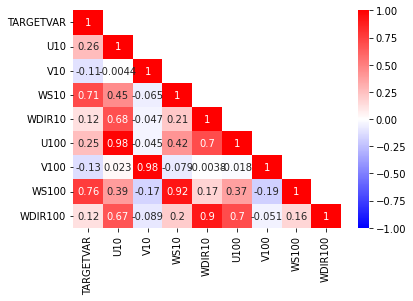

In [302]:
# correlation dataframe
data_temp=data[['TARGETVAR','U10','V10','WS10','WDIR10','U100','V100','WS100','WDIR100']].corr()

for i in range(len(data_temp)):
    for j in range(len(data_temp.columns)):
        if j>i:
            data_temp.iloc[i,j] = np.nan

sns.heatmap(data_temp, cmap='bwr', annot=True, vmin=-1., vmax=1.) 

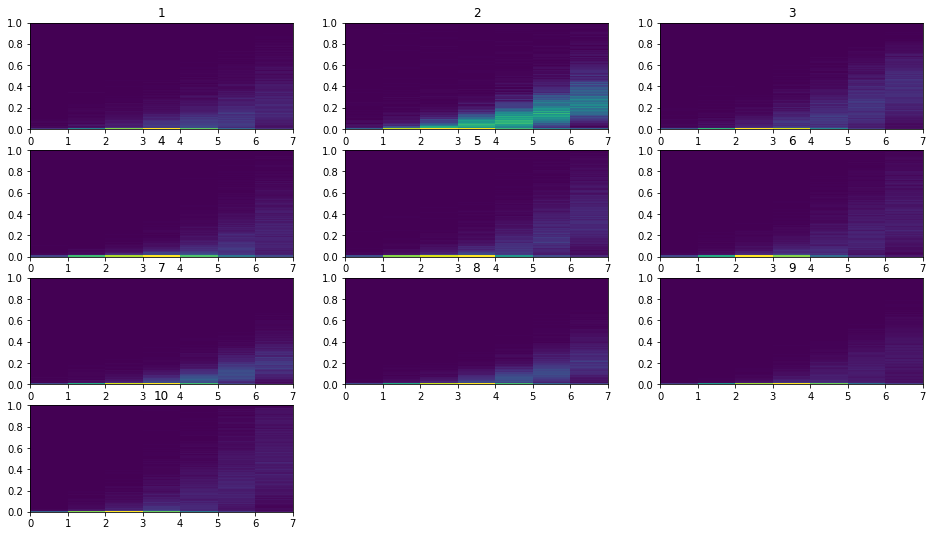

In [303]:
fig,ax = plt.subplots(nrows=4, ncols=3, figsize=(16,9))
ax = ax.ravel()

for i,zone in enumerate(range(1,11)):
    ax[i].hist2d(data=data.loc[data['ZONEID']==zone], x='WS100', y='TARGETVAR',bins=(np.arange(0,24,1),np.arange(0,1.01,.01)),density=True)
    #plt.colorbar()
    ax[i].set_ylim([0,1.])
    ax[i].set_xlim([0,7])
    ax[i].set_title(zone)
ax[-1].remove()
ax[-2].remove()
#sns.jointplot(data['WS100'],data['TARGETVAR'])

---

### some other code snippets ###

In [304]:


# a = pd.DataFrame(data=np.array([[1.,2.,3.],[-1.,5.,6.]]),columns=['A','B','E'])
# b = pd.DataFrame(data=np.array([[1.,2.,6.],[-1.,5.,4.]]),columns=['C','D','E'])
# c = pd.merge(a,b,on='E',how='left')

# print(a)
# print(b)
# print(c)
